# Capstone Project - The Battle of Neighbors: Week 1

## Introduction

Hi there! the objective of this notebook is to use Python's map modules along with Foursquare API to see where is the best point to open an italian restaurant. We want open a high level restaurant, which means that it must be placed in a noble area. I picked the Rio de Janeiro City, where I lived, as a target.

The strategy I chose was to get a visual sample of Rio's districts (not actualy a district, but more like a neighborhood. But I will call them districts through the notebook) and pick the noblest ones, preferably near the beach. Then, I checked how many italian restaurants are in each district. The final shot was to use a choropleth map (heatmap) to have a better visualization and then pick the place where the restaurant should be placed.

For the visual part, I used Geopandas, a module that works with geospatial data in python. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. To get the restaurants, I used Foursquare search API to see how many restaurants are.

## Coding

Let's start importing everything that is necessary:

In [1]:
import pandas as pd
#import numpy as np
#from geopy.geocoders import Nominatim
#from IPython.display import Image 
#from IPython.core.display import HTML
from pandas.io.json import json_normalize
#import folium
import matplotlib as plt

In [2]:
import geocoder
import requests
from bs4 import BeautifulSoup

In [3]:
import geopandas as gpd

Let's start loading Rio de Janeiro's districts using Geopandas:

In [4]:
rio_api = r'https://pgeo3.rio.rj.gov.br/arcgis/rest/services/Basicos/mapa_basico_UTM/MapServer/15/query?where=1%3D1&outFields=*&outSR=4326&f=json'

It is a JSON type, so let's get it:

In [5]:
rio_json = requests.get(rio_api)

It is a huge set of data, so it is better to avoid printing it. But we can use **print(rio_json.json())** if we want to do so.  
Let's import this as a DataFrame using Geopandas

In [6]:
rio_df = gpd.read_file(rio_api)

So far, so good. Let's see if everything is alright:

In [7]:
rio_df.head()

,OBJECTID,Área,NOME,REGIAO_ADM,AREA_PLANE,CODBAIRRO,CODRA,CODBNUM,LINK,SHAPE.STArea(),SHAPE.STLength(),RP,Cod_RP,CODBAIRRO_LONG,geometry
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013 ...,1.705685e+06,24841.426669,Centro,1.1,13,"MULTIPOLYGON (((-43.10567 -22.74888, -43.10568..."
1,326,4.056403e+06,Freguesia (Ilha),ILHA DO GOVERNADOR,3,098,20,98,Freguesia (Ilha) &area=98 ...,4.056403e+06,18303.595717,Ilha do Governador,3.7,98,"MULTIPOLYGON (((-43.17170 -22.77661, -43.17170..."
2,327,9.780465e+05,Bancários,ILHA DO GOVERNADOR,3,097,20,97,Bancários &area=97 ...,9.780465e+05,7758.781282,Ilha do Governador,3.7,97,"MULTIPOLYGON (((-43.18915 -22.78318, -43.18913..."
3,328,1.895742e+07,Galeão,ILHA DO GOVERNADOR,3,104,20,104,Galeão &area=104 ...,1.895742e+07,21510.059220,Ilha do Governador,3.7,104,"MULTIPOLYGON (((-43.22804 -22.78374, -43.22798..."
4,329,1.672546e+06,Tauá,ILHA DO GOVERNADOR,3,101,20,101,Tauá &area=101 ...,1.672546e+06,8246.109606,Ilha do Governador,3.7,101,"POLYGON ((-43.18039 -22.79940, -43.18055 -22.7..."


In [8]:
rio_df.shape

(163, 15)

As we can see, Rio de Janeiro city has 163 districts, split in bigger regions (**REGIAO_ADM**). We can group them by these areas to see what we find:

In [9]:
rio_groups = rio_df.groupby('REGIAO_ADM').groups
rio_groups

{'ANCHIETA                ': Int64Index([20, 29, 30, 33], dtype='int64'),
 'BANGU': Int64Index([161], dtype='int64'),
 'BANGU                   ': Int64Index([51, 62, 159, 160, 162], dtype='int64'),
 'BARRA DA TIJUCA         ': Int64Index([124, 134, 138, 142, 144, 150, 152, 154], dtype='int64'),
 'BOTAFOGO                ': Int64Index([111, 120, 121, 122, 126, 128, 129, 135], dtype='int64'),
 'CAMPO GRANDE            ': Int64Index([57, 78, 79, 87, 158], dtype='int64'),
 'CENTRO': Int64Index([157], dtype='int64'),
 'CENTRO                  ': Int64Index([95], dtype='int64'),
 'CIDADE DE DEUS          ': Int64Index([130], dtype='int64'),
 'COMPLEXO DA MARE        ': Int64Index([38], dtype='int64'),
 'COMPLEXO DO ALEMÃO      ': Int64Index([49], dtype='int64'),
 'COPACABANA              ': Int64Index([139, 140], dtype='int64'),
 'GUARATIBA               ': Int64Index([123, 149, 153], dtype='int64'),
 'ILHA DO GOVERNADOR      ': Int64Index([1, 2, 3, 4, 5, 6, 8, 10, 13, 16, 18, 22, 26, 27, 4

We are not interested in most of the information concerning codes, so we are going to clean our DF:

In [10]:
rio_clean = rio_df[['NOME','REGIAO_ADM','CODBAIRRO','geometry']]
rio_clean.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry
0,Paquetá,PAQUETA,013,"MULTIPOLYGON (((-43.10567 -22.74888, -43.10568..."
1,Freguesia (Ilha),ILHA DO GOVERNADOR,098,"MULTIPOLYGON (((-43.17170 -22.77661, -43.17170..."
2,Bancários,ILHA DO GOVERNADOR,097,"MULTIPOLYGON (((-43.18915 -22.78318, -43.18913..."
3,Galeão,ILHA DO GOVERNADOR,104,"MULTIPOLYGON (((-43.22804 -22.78374, -43.22798..."
4,Tauá,ILHA DO GOVERNADOR,101,"POLYGON ((-43.18039 -22.79940, -43.18055 -22.7..."


Where **NOME** = name and **CODBAIRRO** is a code for the district

We are aiming to open an italian restaurant and we want to see where at in the noblest areas. So we are interested in **REGIAO_ADM** corresponding to BARRA DA TIJUCA, BOTAFOGO, CENTRO and LAGOA. Let's check what districts are in LAGOA region:

rio_clean.groupby('REGIAO_ADM').get_group('LAGOA')

There was an error. That's because LAGOA is really 'LAGOA &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;', so let's get rid of theses spaces:

In [11]:
rio_clean.NOME = rio_clean.NOME.str.strip()
rio_clean.REGIAO_ADM = rio_clean.REGIAO_ADM.str.strip()

C:\Users\Andre\anaconda3\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Let's check again:

In [12]:
rio_clean.groupby('REGIAO_ADM').get_group('LAGOA').NOME

137    Jardim Botânico
141              Lagoa
143              Gávea
145             Leblon
146            Ipanema
147        São Conrado
151            Vidigal
Name: NOME, dtype: object

We can see that the Lagoa region has 7 disctricts.  
  
We will concatenate the other regions in a new DF:

In [13]:
r_grouped = rio_clean.groupby('REGIAO_ADM')
zsc = pd.concat([group for (name, group) in r_grouped if name in ['LAGOA', 'COPACABANA', 'CENTRO', 'BOTAFOGO','BARRA DA TIJUCA']])

Let's check:

In [14]:
print(zsc)

                         NOME       REGIAO_ADM CODBAIRRO  \
124             Vargem Grande  BARRA DA TIJUCA       131   
134                   Camorim  BARRA DA TIJUCA       129   
138            Vargem Pequena  BARRA DA TIJUCA       130   
142                 Itanhangá  BARRA DA TIJUCA       127   
144           Barra da Tijuca  BARRA DA TIJUCA       128   
150  Recreio dos Bandeirantes  BARRA DA TIJUCA       132   
152                       Joá  BARRA DA TIJUCA       126   
154                   Grumari  BARRA DA TIJUCA       133   
111                    Glória         BOTAFOGO       016   
120                    Catete         BOTAFOGO       018   
121                  Flamengo         BOTAFOGO       015   
122               Laranjeiras         BOTAFOGO       017   
126               Cosme Velho         BOTAFOGO       019   
128                  Botafogo         BOTAFOGO       020   
129                      Urca         BOTAFOGO       022   
135                   Humaitá         BO

Let's see in a map, but first we will obtain the coordinates for displying the districts' names:

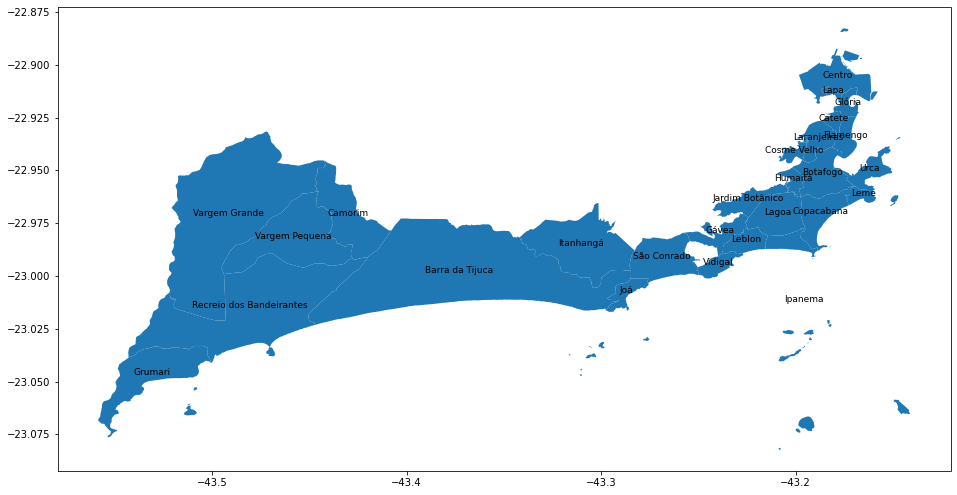

In [15]:
zsc['coords'] = zsc['geometry'].apply(lambda x: x.representative_point().coords[:])
zsc['coords'] = [coords[0] for coords in zsc['coords']]
ax = zsc.plot(figsize = (16,10))
zsc.apply(lambda x: ax.annotate(s=x.NOME, 
                                xy=x.geometry.centroid.coords[0], 
                                ha='center', 
                                size = 9, 
                                color = 'black', 
                                ),axis=1);

Compared with the other districts:

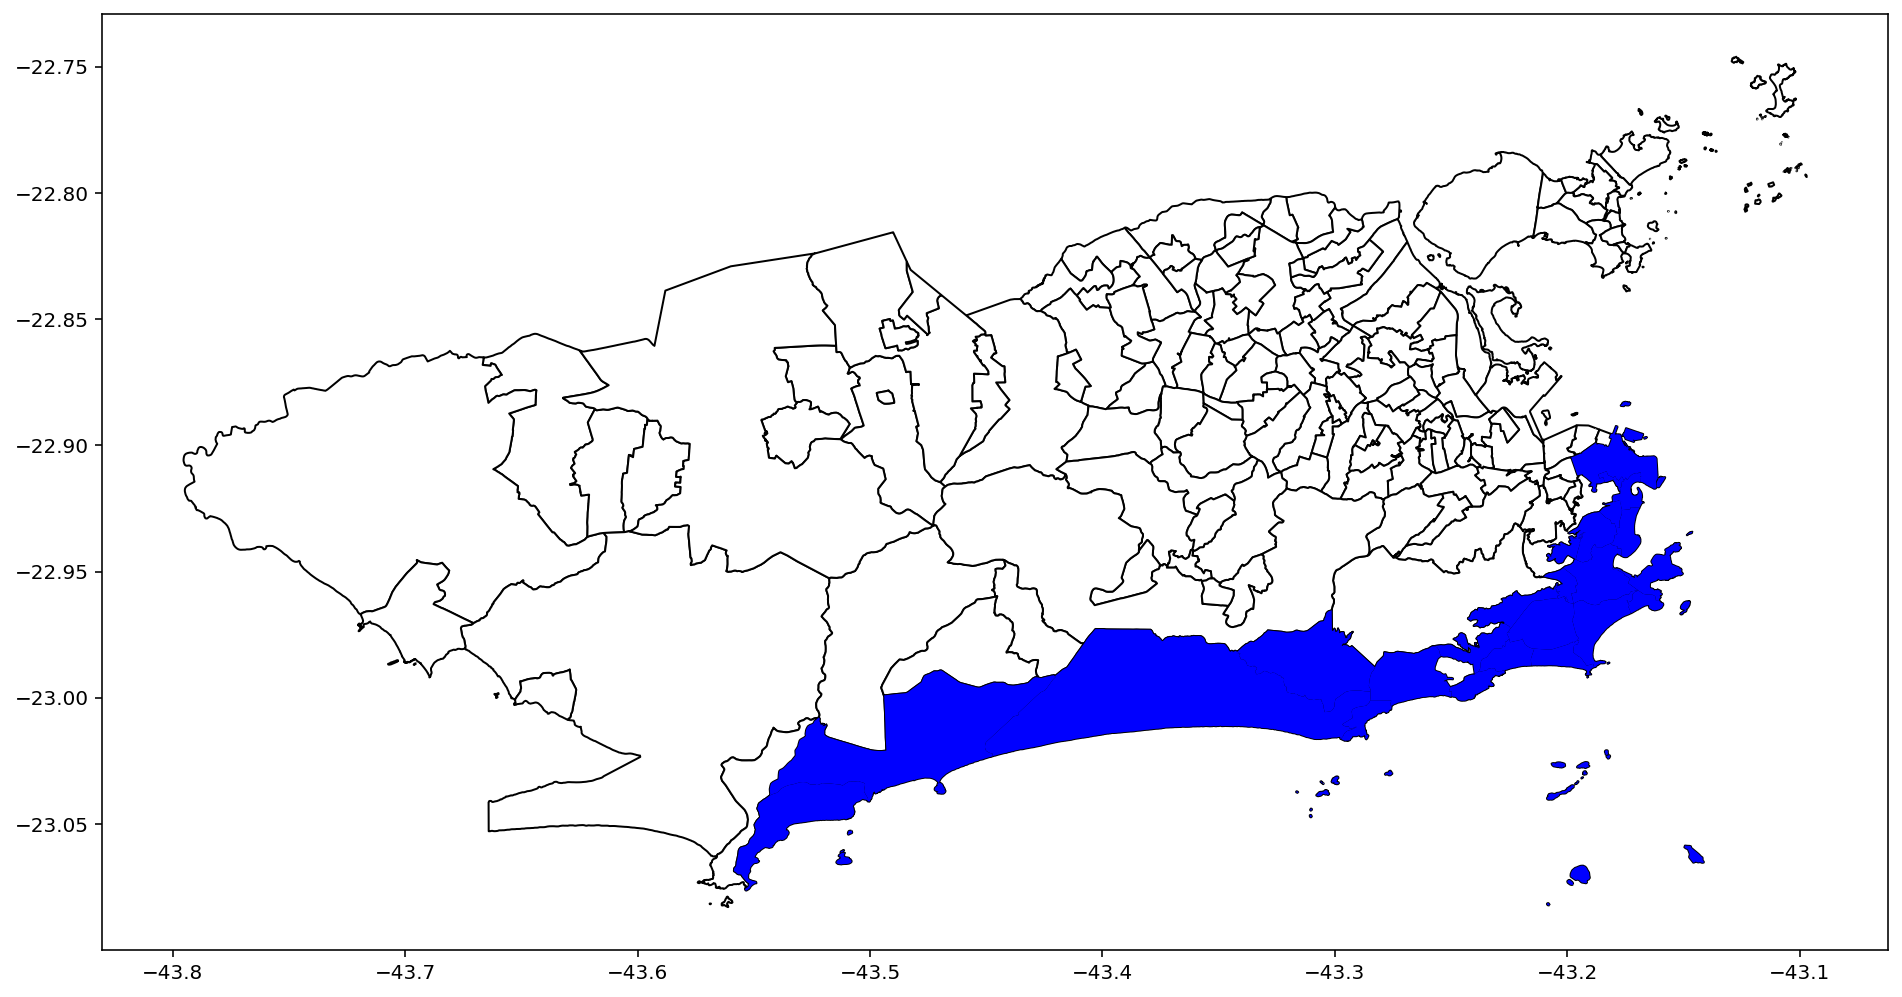

In [69]:
base = rio_clean.plot(color='white', edgecolor='black', figsize = (16,10))
zsc.plot(ax=base, color='blue');

Let's check again zsc:

In [17]:
zsc.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry,coords
124,Vargem Grande,BARRA DA TIJUCA,131,"POLYGON ((-43.44281 -22.94526, -43.44219 -22.9...","(-43.49577342658546, -22.976312858989203)"
134,Camorim,BARRA DA TIJUCA,129,"POLYGON ((-43.43624 -22.94866, -43.43623 -22.9...","(-43.43290640793579, -22.968721809565075)"
138,Vargem Pequena,BARRA DA TIJUCA,130,"POLYGON ((-43.43854 -22.98201, -43.43819 -22.9...","(-43.457557071471705, -22.97939754918046)"
142,Itanhangá,BARRA DA TIJUCA,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...","(-43.31202118738386, -22.9854727536549)"
144,Barra da Tijuca,BARRA DA TIJUCA,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...","(-43.37343120677338, -22.997902330024047)"


Let's split the centroids in two columns: longitude and latitude. The centroids are the coordinate points that are equals to the edges.

In [18]:
zsc['longitude'] = zsc.centroid.x
zsc['latitude'] = zsc.centroid.y

<ipython-input-18-7fcac361c12e>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zsc['longitude'] = zsc.centroid.x
<ipython-input-18-7fcac361c12e>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zsc['latitude'] = zsc.centroid.y


In [19]:
zsc.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry,coords,longitude,latitude
124,Vargem Grande,BARRA DA TIJUCA,131,"POLYGON ((-43.44281 -22.94526, -43.44219 -22.9...","(-43.49577342658546, -22.976312858989203)",-43.491810,-22.971778
134,Camorim,BARRA DA TIJUCA,129,"POLYGON ((-43.43624 -22.94866, -43.43623 -22.9...","(-43.43290640793579, -22.968721809565075)",-43.430378,-22.971515
138,Vargem Pequena,BARRA DA TIJUCA,130,"POLYGON ((-43.43854 -22.98201, -43.43819 -22.9...","(-43.457557071471705, -22.97939754918046)",-43.458550,-22.982479
142,Itanhangá,BARRA DA TIJUCA,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...","(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
144,Barra da Tijuca,BARRA DA TIJUCA,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...","(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700


We are not going to work with some districts, so we'll get rid of them:

In [20]:
zsc = zsc[3:]

In [71]:
zsc.head()

,NOME,REGIAO_ADM,Numero_de_restaurantes,CODBAIRRO,geometry,coords,longitude,latitude
142,Itanhangá,BARRA DA TIJUCA,0,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...","(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
144,Barra da Tijuca,BARRA DA TIJUCA,3,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...","(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700
150,Recreio dos Bandeirantes,BARRA DA TIJUCA,3,132,"POLYGON ((-43.43787 -22.99512, -43.43744 -22.9...","(-43.47024396165992, -23.01510158223853)",-43.480828,-23.015096
152,Joá,BARRA DA TIJUCA,0,126,"POLYGON ((-43.27559 -23.00329, -43.27559 -23.0...","(-43.29025340031879, -23.00905426219122)",-43.287221,-23.007962
154,Grumari,BARRA DA TIJUCA,0,133,"MULTIPOLYGON (((-43.50815 -23.03310, -43.50715...","(-43.54288482797882, -23.054642062865497)",-43.530915,-23.046759


Now we are ready to see how many italian restaurants are in these neighbours. We will check with Foursquare:

In [22]:
CLIENT_ID = '3BMB5H2JEK3J34M3KWYNYBJXMC3CZO5U4LIS0TUIZVZIHIX4' # your Foursquare ID
CLIENT_SECRET = 'BWOJIKVLFAP2H3TZMBMYT5QBFMXPG1POTP3XSX5TADOKTGJQ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 3BMB5H2JEK3J34M3KWYNYBJXMC3CZO5U4LIS0TUIZVZIHIX4
CLIENT_SECRET:BWOJIKVLFAP2H3TZMBMYT5QBFMXPG1POTP3XSX5TADOKTGJQ


Let's try to find an italian restaurant in downtown district (centro):

In [23]:
i_rest = 'italian restaurant'
radius = 1000
latitude = -22.906296
longitude = -43.178565

In [24]:
page = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.\
format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, i_rest, radius, LIMIT)

In [25]:
results = requests.get(page).json()
results

{'meta': {'code': 200, 'requestId': '5fc7d153f5ceae3a1252a81f'},
 'response': {'venues': [{'id': '4baa39b0f964a52036553ae3',
    'name': 'Ô Matos restaurant',
    'location': {'address': 'R. Sete de Setembro',
     'lat': -22.90516247466809,
     'lng': -43.178071936243484,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.90516247466809,
       'lng': -43.178071936243484}],
     'distance': 135,
     'cc': 'BR',
     'city': 'Rio de Janeiro',
     'state': 'RJ',
     'country': 'Brasil',
     'formattedAddress': ['R. Sete de Setembro',
      'Rio de Janeiro, RJ',
      'Brasil']},
    'categories': [{'id': '4bf58dd8d48988d16b941735',
      'name': 'Brazilian Restaurant',
      'pluralName': 'Brazilian Restaurants',
      'shortName': 'Brazilian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1606930771',
    'hasPerk': False},
   {'id': '501173cfe4b01be621292bc3'

We have to apply this search for the other 23 districts. So let's create a function that extracts the data and transforms to a DataFrame

In [26]:
def ext_api(latitude, longitude):
    CLIENT_ID = '3BMB5H2JEK3J34M3KWYNYBJXMC3CZO5U4LIS0TUIZVZIHIX4' 
    CLIENT_SECRET = 'BWOJIKVLFAP2H3TZMBMYT5QBFMXPG1POTP3XSX5TADOKTGJQ'
    VERSION = '20180604'
    LIMIT = 30
    i_rest = 'italian'
    radius = 1000
    page = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.\
    format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, i_rest, radius, LIMIT)
    results = requests.get(page).json()
    venues = results['response']['venues']
    ita_df = json_normalize(venues)
    return ita_df

In [27]:
ita_app = ext_api(-22.985885,-43.310079)

<ipython-input-26-b5e00302cce6>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  ita_df = json_normalize(venues)


In [51]:
ita_app = ext_api(-22.985885,-43.310079)
#creating an empty list to see how many restaurants are in each district
counter = []
#Using a for loop to weep the radius through the centroids
for (lat, long) in zsc[['latitude', 'longitude']].itertuples(index = False):
    ita_rest = ext_api(lat,long)
    index = len(ita_rest.index)
    counter.append(index)
    #concatenate the dataframes
    ita_app = ita_app.append([ita_rest])
    
ita_app.shape

<ipython-input-26-b5e00302cce6>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  ita_df = json_normalize(venues)


(56, 18)

In [59]:
len(counter)

24

In [53]:
sum(counter)

56

In [45]:
#grouping the dataframes
ita_group = ita_app.groupby(["id"]).count()
ita_group.head()

,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.postalCode,location.neighborhood
id,,,,,,,,,,,,,,,,,
4b2a5596f964a52060a724e3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4b7feef5f964a5204a4530e3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4ba4af4ef964a52023ac38e3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,0
4bb0d639f964a5209e613ce3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4bc10818abf495215368c093,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0


In [46]:
ita_group.shape

(41, 17)

In [40]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

filtered_columns = ['name', 'categories'] + [col for col in ita_app.columns if col.startswith('location.')] + ['id']
dataframe_filtered = ita_app.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

In [42]:
dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,postalCode,neighborhood,id
0,Italian Fast,Brazilian Restaurant,Av. Das Américas,-22.997811,-43.363454,"[{'label': 'display', 'lat': -22.9978108853515...",971,BR,Rio de Janeiro,RJ,Brasil,"[Av. Das Américas, Rio de Janeiro, RJ, Brasil]",NaN,NaN,NaN,4d80f0c47c956dcb447bea7b
1,Spoleto Culinária Italiana,Italian Restaurant,CasaShopping,-22.993164,-43.363681,"[{'label': 'display', 'lat': -22.9931641762214...",1126,BR,Rio de Janeiro,RJ,Brasil,"[CasaShopping (Bloco G, 1º Piso), Rio de Janei...","Bloco G, 1º Piso",22775-900,NaN,53ea5287498e13fbab67c982
2,Spoleto Culinária Italiana,Italian Restaurant,Carrefour,-22.997800,-43.363525,"[{'label': 'display', 'lat': -22.9978, 'lng': ...",964,BR,Rio de Janeiro,RJ,Brasil,"[Carrefour, Rio de Janeiro, RJ, 22640-102, Bra...",NaN,22640-102,NaN,5b3503ba9e0d54002c6e4f8f
0,Italian Box,Italian Restaurant,NaN,-23.024049,-43.481639,"[{'label': 'display', 'lat': -23.024049, 'lng'...",1000,BR,NaN,NaN,Brasil,[Brasil],NaN,NaN,NaN,51b51eec498e73414b0ac6a5
1,Italianbox,Italian Restaurant,NaN,-23.024000,-43.481757,"[{'label': 'display', 'lat': -23.024, 'lng': -...",995,BR,NaN,NaN,Brasil,[Brasil],NaN,NaN,NaN,51b4f2d6498e546d13aabd55


In [43]:
dataframe_filtered.shape

(56, 16)

Now let's see how many italian restaurants are in each district (Number of restaurantes - Número de restaurantes):

In [54]:
zsc.insert(2, "Numero_de_restaurantes", counter, True) 

In [70]:
zsc.head(24)

,NOME,REGIAO_ADM,Numero_de_restaurantes,CODBAIRRO,geometry,coords,longitude,latitude
142,Itanhangá,BARRA DA TIJUCA,0,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...","(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
144,Barra da Tijuca,BARRA DA TIJUCA,3,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...","(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700
150,Recreio dos Bandeirantes,BARRA DA TIJUCA,3,132,"POLYGON ((-43.43787 -22.99512, -43.43744 -22.9...","(-43.47024396165992, -23.01510158223853)",-43.480828,-23.015096
152,Joá,BARRA DA TIJUCA,0,126,"POLYGON ((-43.27559 -23.00329, -43.27559 -23.0...","(-43.29025340031879, -23.00905426219122)",-43.287221,-23.007962
154,Grumari,BARRA DA TIJUCA,0,133,"MULTIPOLYGON (((-43.50815 -23.03310, -43.50715...","(-43.54288482797882, -23.054642062865497)",-43.530915,-23.046759
111,Glória,BOTAFOGO,2,016,"POLYGON ((-43.16828 -22.91094, -43.16825 -22.9...","(-43.17492363193883, -22.918170280827155)",-43.173277,-22.919102
120,Catete,BOTAFOGO,2,018,"POLYGON ((-43.17643 -22.92562, -43.17645 -22.9...","(-43.180833660893924, -22.92713012109943)",-43.180188,-22.926646
121,Flamengo,BOTAFOGO,2,015,"POLYGON ((-43.16887 -22.92465, -43.16887 -22.9...","(-43.17492210117102, -22.93434828625649)",-43.174182,-22.934711
122,Laranjeiras,BOTAFOGO,1,017,"POLYGON ((-43.18144 -22.92950, -43.18081 -22.9...","(-43.18652517035371, -22.936319414528384)",-43.188493,-22.935348
126,Cosme Velho,BOTAFOGO,1,019,"POLYGON ((-43.19638 -22.94503, -43.19956 -22.9...","(-43.20046825501165, -22.94063589127018)",-43.200735,-22.941586


We can now apply a choropleth map to easily see italian restaurants distribuition

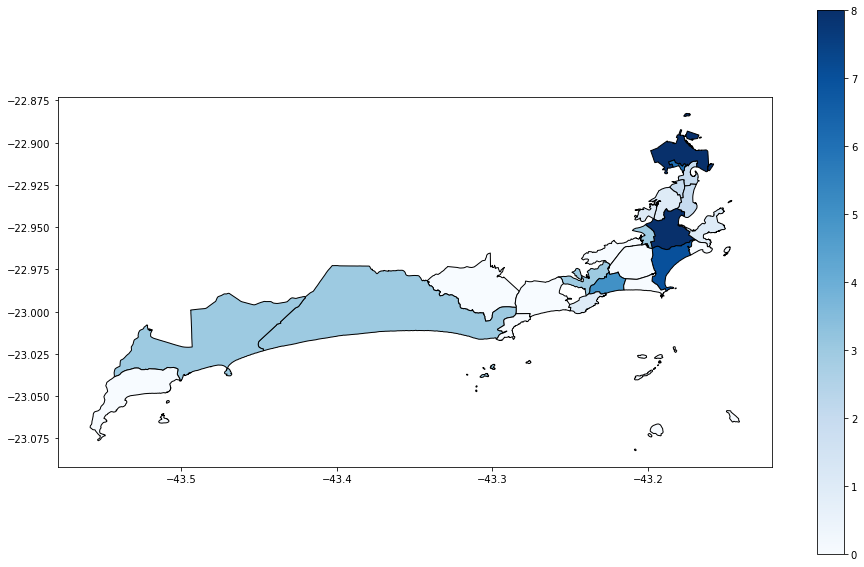

In [60]:
zsc.plot(column = 'Numero_de_restaurantes', 
         cmap = 'Blues', 
         figsize = (16,10), 
         legend = True, 
         edgecolor = 'black')

As we can see, there are noble places where there is no italian restaurants, and other places with 8. As a former Rio dweller, I know that Itanhangá, Joá and São Conrado are not good places to open a restaurant, because of their geography. The best point considering the map density is Ipanema, which is a beach region known worldwide and, surprisingly, with no italian restaurants. 